In [1]:
import numpy as np

import scipy.constants as cs
from scipy.optimize import curve_fit
import scipy.ndimage as ndimage
from ImageProcessing import *

import matplotlib.pyplot as plt
import matplotlib.scale as scale

import tqdm
import scipy.io

import csv

# Loading Data

In [2]:
data = scipy.io.loadmat('jun1_run9.mat')
n_loops = 20
lattice_shape = np.array([10, 10])
stack = data['stack']

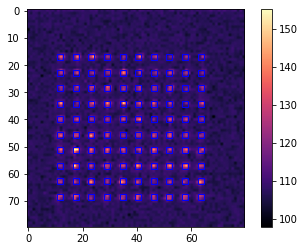

[(2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720, 6, 6), (2720

In [3]:
processor = GreenImageProcessor(stack, lattice_shape, 20)
processor.plot()
crops, labels = processor.make_dataset(1)

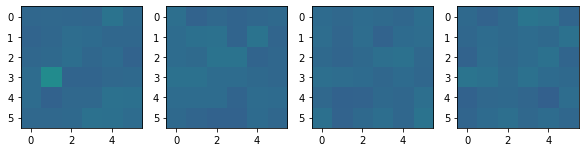

In [4]:
i, j, k = np.random.randint(img.n_tweezers), np.random.randint(img.n_loops), np.random.randint(img.per_loop - 4)

fig, axs = plt.subplots(1, 4, figsize=(10, 20))

for n in range(4):
    axs[n].imshow(crops[img.crop_index(i, j, k + n)], vmin=img.stack.min(), vmax=img.stack.max())

9


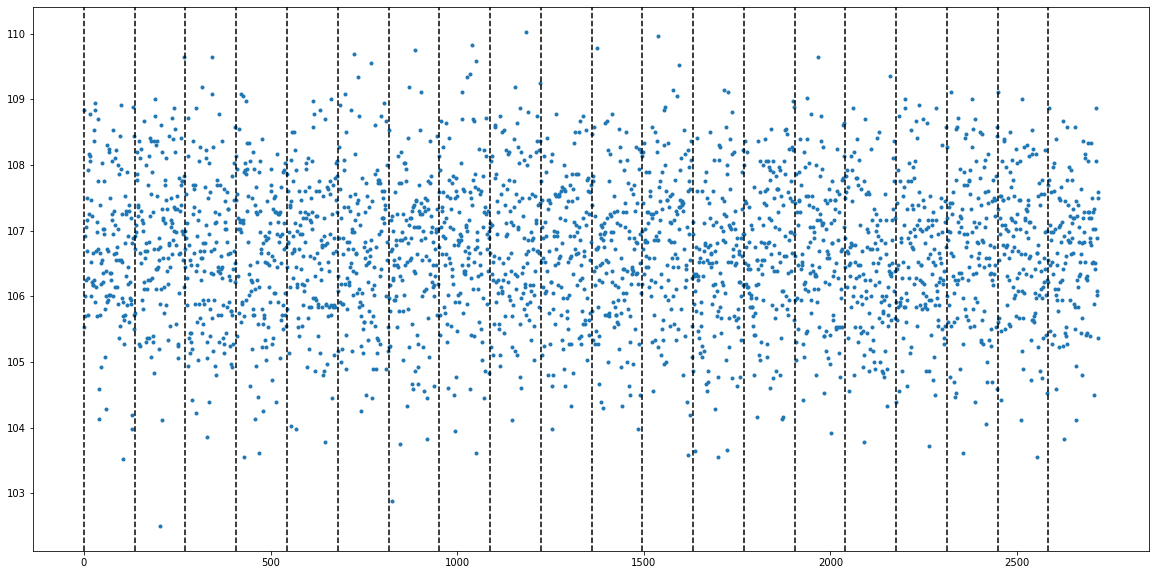

In [5]:
#i = 0
plt.figure(figsize=(20, 10))
plt.plot(np.mean(crops[img.crop_index(i, 0, 0): img.crop_index(i + 1, 0, 0) - 1], axis=(1, 2)), '.')
print(i)
for i in range(n_loops):
    plt.axvline(i * img.per_loop, color='k', linestyle='--')

In [6]:
tweezer = 96
high_threshold = 113
low_threshold = 110
avg = np.mean(crops[img.crop_index(tweezer, 0, 0): img.crop_index(tweezer + 1, 0, 0)], axis=(1, 2))
loops = avg.reshape((n_loops, -1))
bright_vals = bright_indices = dark_vals = dark_indices = unknown_vals = unknown_indices = np.array([])
for i in range(n_loops):
    last_above_thresh = np.where(loops[i] > high_threshold)[-1] + 1
    first_below_thresh = np.where(loops[i] < low_threshold)[0]
    if any(last_above_thresh) and any(first_below_thresh):
        split = np.split(loops[i], [last_above_thresh[-1], first_below_thresh[0]])
        bright_vals = np.append(bright_vals, split[0])
        bright_indices = np.append(bright_indices, np.arange(img.per_loop * i, img.per_loop * i + last_above_thresh[-1]))
        unknown_vals = np.append(unknown_vals, split[1])
        unknown_indices = np.append(unknown_indices, np.arange(img.per_loop * i + last_above_thresh[-1], img.per_loop * i + first_below_thresh[0]))
        dark_vals = np.append(dark_vals, split[2])
        dark_indices = np.append(dark_indices, np.arange(img.per_loop * i + first_below_thresh[0], img.per_loop * (i + 1)))
    elif any(last_above_thresh):
        split = np.split(loops[i], last_above_thresh[-1:])
        bright_vals = np.append(bright_vals, split[0])
        bright_indices = np.append(bright_indices, np.arange(img.per_loop * i, img.per_loop * i + last_above_thresh[-1]))
        unknown_vals = np.append(unknown_vals, split,[1])
        unknown_indices = np.append(unknown_indices, np.arange(img.per_loop * i + last_above_thresh[-1], img.per_loop * (i + 1)))
    elif any(first_below_thresh):
        if first_below_thresh[0] == 0:
            dark_vals = np.append(dark_vals, loops[i])
            dark_indices = np.append(dark_indices, np.arange(img.per_loop * i + first_below_thresh[0], img.per_loop * (i + 1)))
        else:
            split = np.split(loops[i], first_below_thresh[:1])
            unknown_vals = np.append(unknown_vals, split[0])
            unknown_indices = np.append(unknown_indices, np.arange(img.per_loop * i, img.per_loop * i + first_below_thresh[0]))
            dark_vals = np.append(dark_vals, split[1])
            dark_indices = np.append(dark_indices, np.arange(img.per_loop * i + first_below_thresh[0], img.per_loop * (i + 1)))
    else:
        unknown_vals = np.append(unknown_vals, loops[i])
        unknown_indices = np.append(unknown_indices, np.arange(img.per_loop * i, img.per_loop * (i + 1)))

bright_indices.sort()
dark_indices.sort()
unknown_indices.sort()
    

4


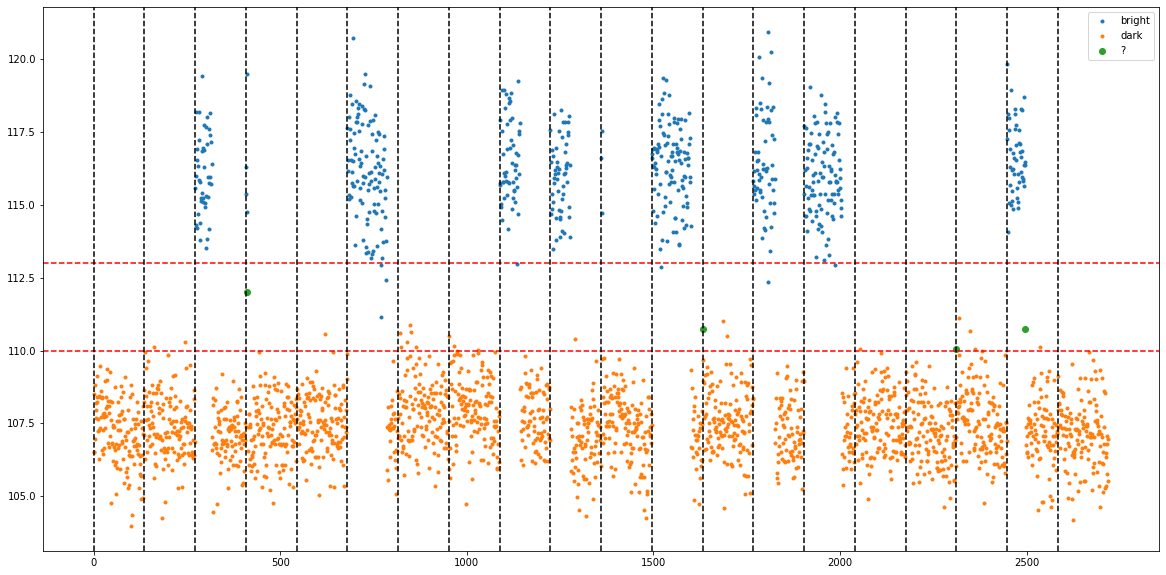

In [7]:
print(len(unknown_vals))
plt.figure(figsize=(20, 10))
plt.plot(bright_indices, bright_vals, '.', label='bright')
plt.plot(dark_indices, dark_vals, '.', label='dark')
plt.plot(unknown_indices, unknown_vals, 'o', label='?')
plt.axhline(high_threshold, color='r', linestyle='--')
plt.axhline(low_threshold, color='r', linestyle='--')
plt.legend()
for i in range(n_loops):
    plt.axvline(i * img.per_loop, color='k', linestyle='--')

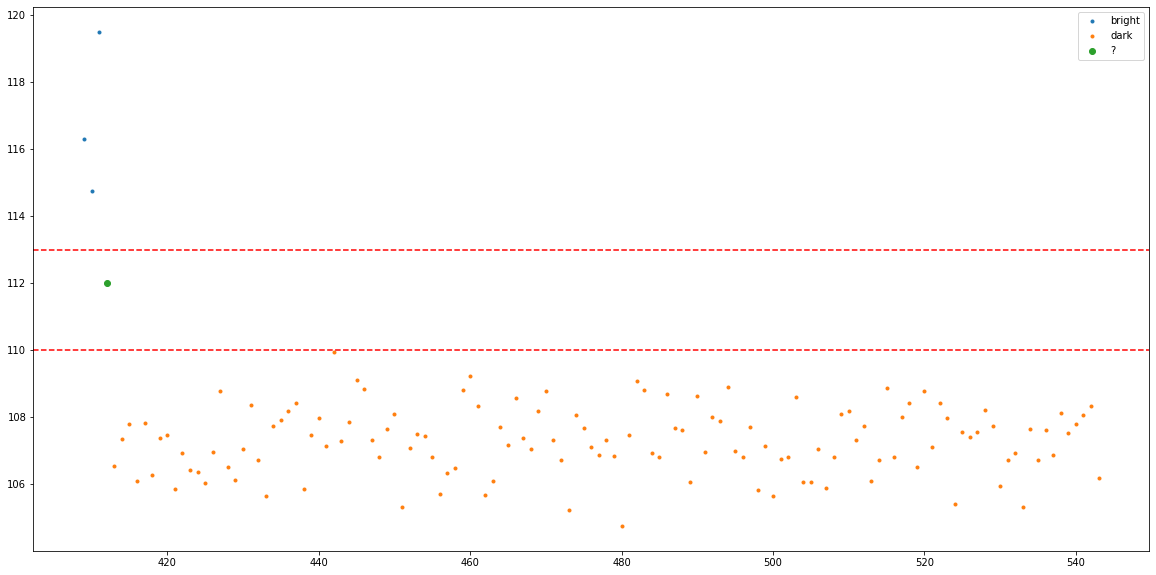

In [8]:
loop_num = 3
low = img.per_loop * loop_num
high = img.per_loop * (loop_num + 1)
bright_mask = (low < bright_indices) & (bright_indices < high)
dark_mask = (low < dark_indices) & (dark_indices < high)
unknown_mask = (low < unknown_indices) & (unknown_indices < high)

plt.figure(figsize=(20, 10))
plt.plot(bright_indices[bright_mask], bright_vals[bright_mask], '.', label='bright')
plt.plot(dark_indices[dark_mask], dark_vals[dark_mask], '.', label='dark')
plt.plot(unknown_indices[unknown_mask], unknown_vals[unknown_mask], 'o', label='?')
plt.axhline(high_threshold, color='r', linestyle='--')
plt.axhline(low_threshold, color='r', linestyle='--')
plt.legend()

In [9]:
labels = 

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
